# Boston房价练习

## 获取数据

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()
#假设此前数据已经整理干净，收拾整齐

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 简单可视化和分析

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

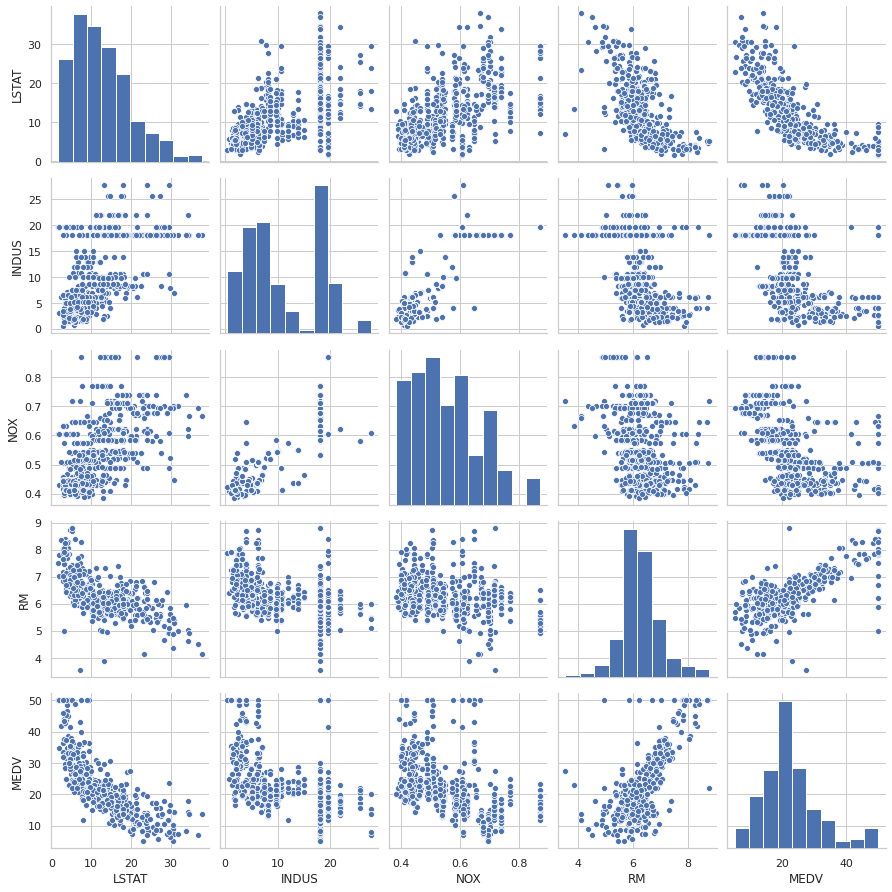

In [3]:
sns.set(style='whitegrid', context='notebook') #设置sns格式
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV'] #选择参与分析的列
# 低收入人群占比、非零售商业用地比例、一氧化氮浓度、每栋房屋平均客房数、同类房屋价格的中位数
sns.pairplot(data=df[cols])
plt.tight_layout()
plt.show()
# pip install -U升级了numpy和pandas版本，解决了绘图问题

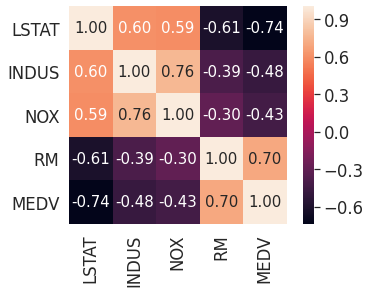

In [4]:
import numpy as np

#绘制皮尔森相关系数
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.show()

In [ ]:
# 以上对数据的基本特征进行了分析
# 线性回归

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
X = df[['RM']].values  # 每栋房屋平均客房数
y = df['MEDV'].values
slr = LinearRegression() # 实例化，优化拟合
slr.fit(X, y) # 面像对象进行fit
y_pred = slr.predict(X)

#打印fit结果的斜率和截距
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


In [8]:
# 区别于解析解，计算量更小
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

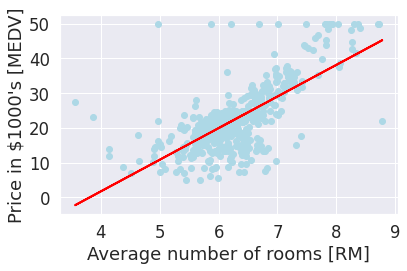

In [9]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
plt.show()

## RANSAC用于提高Linear Regression的鲁棒性

用一套算法判断inliers和outliers

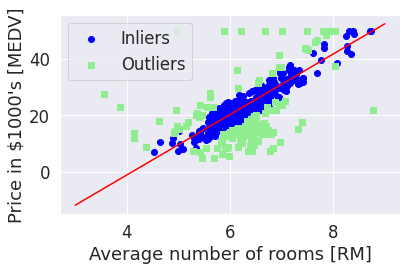

In [10]:
from sklearn.linear_model import RANSACRegressor

# 只使用内点进行优化拟合的模型，截距和斜率发生变化。
# 需要预设参数，例如最大迭代次数和残差阈值，可能影响模型性能。

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_error',   #'squared_error', 'absolute_error'
                         residual_threshold=5.0, 
                         random_state=0)

ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [12]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## 评估回归模型的性能

In [13]:
from sklearn.model_selection import train_test_split

# 全部特征都考虑！
X = df.iloc[:, :-1].values  # 除去最后一列，所有的特征走你！
y = df['MEDV'].values

# 数据切分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [14]:
# 丢给LinearRegression进行训练

slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [ ]:
# 检验训练结果
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# MSE: Mean squared error regression loss。
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
# R2_score: 用均值表达误差基准。
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 添加正则化部分

In [ ]:
# lasso L1 正则
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)  # L1正则化
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)